In [1]:
import awkward as ak
import os
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import warnings
import matplotlib.pyplot as plt
import numpy as np
import hist
import json
import mplhep as hep

In [2]:
plt.style.use(hep.style.CMS)

In [3]:
qcd = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/mc'
for i in os.listdir(path):
    if 'qcd' in i:
        qcd_sample = ak.from_parquet(f'{path}/{i}/*')
        qcd_sample['GenJetAK8'] = qcd_sample.GenJetAK8[qcd_sample.goodjets.genJetAK8Idx]
        qcd_sample['goodjets', 'isGluon'] = (qcd_sample.GenJetAK8.partonFlavour == 21)

        # qcd_sample["goodjets"] = qcd_sample.goodjets[qcd_sample.goodjets.btag_count == 0]
        # mask = ~ak.is_none(ak.firsts(qcd_sample.goodjets))
        # qcd_sample = qcd_sample[mask]
              
        qcd[i] = qcd_sample

In [4]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [5]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [6]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [7]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [8]:
def make_scaled_hist(prefix, var_name, range_down, range_up, bins=40, which_index=None, absv=False):
    hists = {}
    for i in qcd:
        new_hist = hist.Hist.new.Reg(bins, range_down, range_up, 
                                     name='variable', label=var_name).Weight()
        if which_index==None:
            to_fill = qcd[i][prefix][var_name]
        else:
            to_fill = qcd[i][prefix][var_name][:,which_index]
        if absv:
            to_fill = abs(to_fill)
        new_hist.fill(variable=to_fill)
        hists[i] = new_hist
        
    for i in hists:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
        hists[i].view(flow=True)[:] *= scale

    sum_hist = sum([hists[i] for i in hists])

    return sum_hist

In [9]:
qcd_softcounts = make_scaled_hist('GenJetAK8', 'partonFlavour', 0, 22, 22, 2, absv=True)

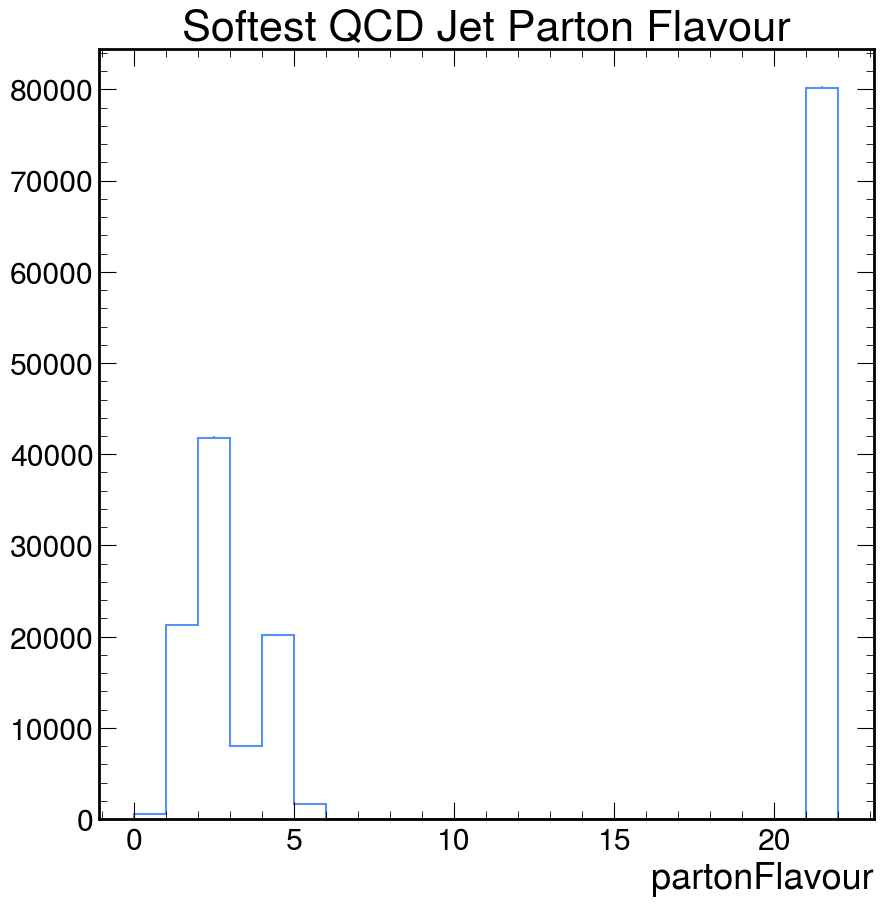

In [10]:
qcd_softcounts.plot1d()
plt.title('Softest QCD Jet Parton Flavour')
plt.show()

In [11]:
sum(qcd_softcounts[20:].values()) / (sum(qcd_softcounts[:6].values()) + sum(qcd_softcounts[20:].values()))

0.46174768161948354

In [12]:
qcd_midcounts = make_scaled_hist('GenJetAK8', 'partonFlavour', 0, 22, 22, 1, absv=True)

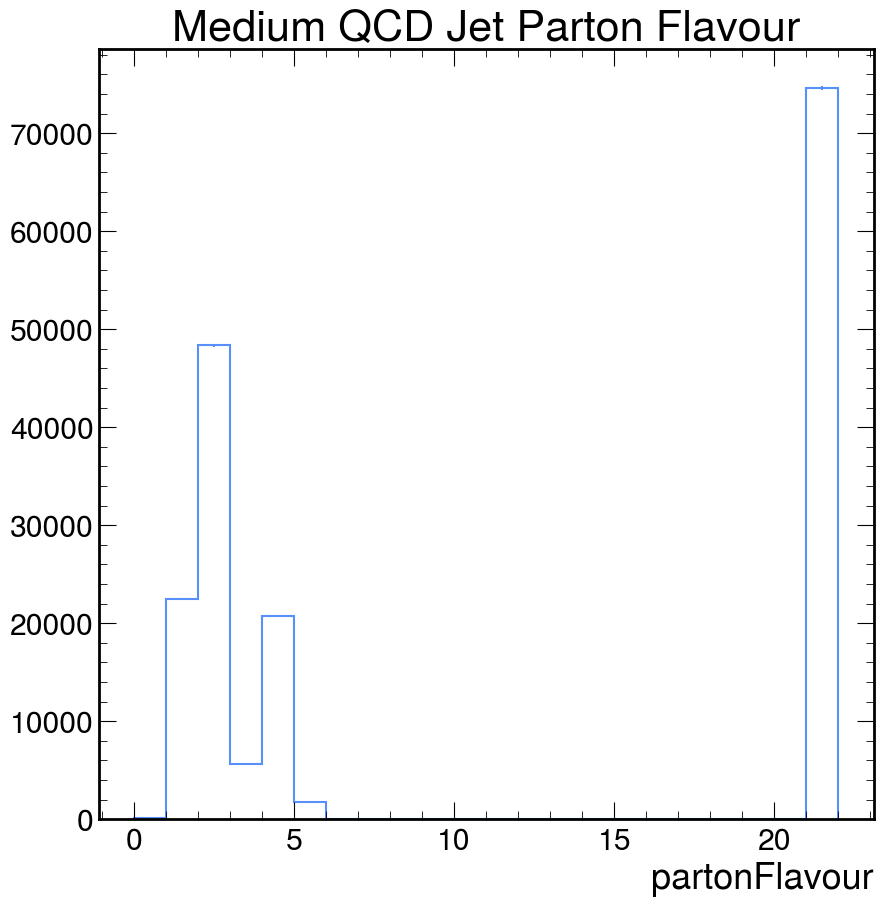

In [13]:
qcd_midcounts.plot1d()
plt.title('Medium QCD Jet Parton Flavour')
plt.show()

In [14]:
sum(qcd_midcounts[20:].values()) / (sum(qcd_midcounts[:6].values()) + sum(qcd_midcounts[20:].values()))

0.42978633108828107

In [15]:
qcd_leadcounts = make_scaled_hist('GenJetAK8', 'partonFlavour', 0, 22, 22, 0, absv=True)

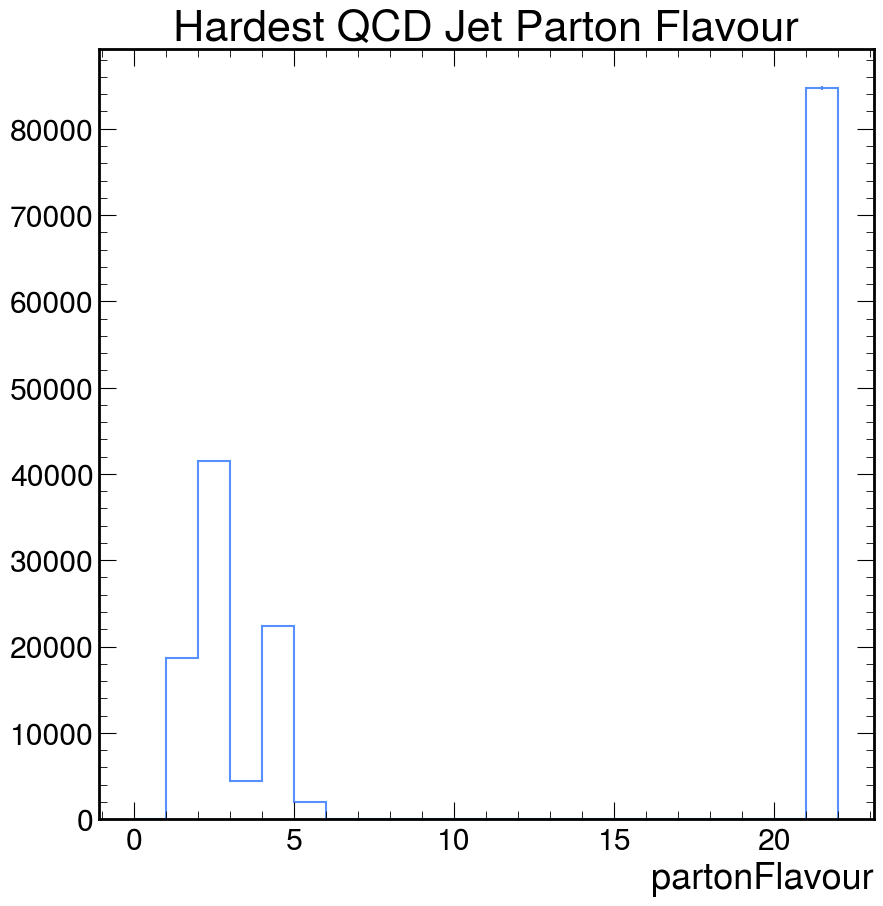

In [16]:
qcd_leadcounts.plot1d()
plt.title('Hardest QCD Jet Parton Flavour')
plt.show()

In [17]:
sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:6].values()) + sum(qcd_leadcounts[20:].values()))

0.48801215756429545

In [17]:
qcd_softeta = make_scaled_hist('GenJetAK8', 'eta', -2.4, 2.4, bins=40, which_index=2, absv=False)
qcd_mideta = make_scaled_hist('GenJetAK8', 'eta', -2.4, 2.4, bins=40, which_index=1, absv=False)
qcd_leadeta = make_scaled_hist('GenJetAK8', 'eta', -2.4, 2.4, bins=40, which_index=0, absv=False)

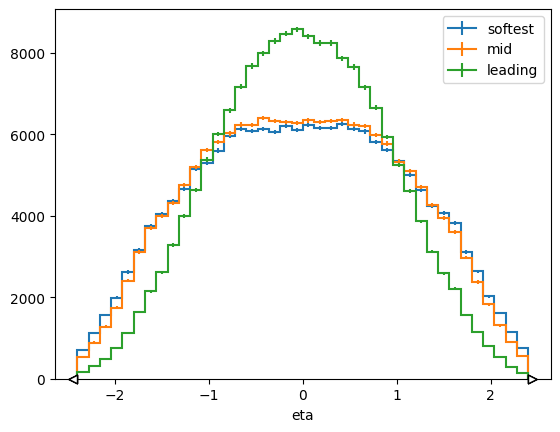

In [18]:
qcd_softeta.plot1d(label='softest')
qcd_mideta.plot1d(label='mid')
qcd_leadeta.plot1d(label='leading')
plt.legend()
plt.show()

In [19]:
qcd_softb = make_scaled_hist('goodjets', 'btag_count', 0, 10, bins=40, which_index=2, absv=False)
qcd_midb = make_scaled_hist('goodjets', 'btag_count', 0, 10, bins=40, which_index=1, absv=False)
qcd_leadb = make_scaled_hist('goodjets', 'btag_count', 0, 10, bins=40, which_index=0, absv=False)

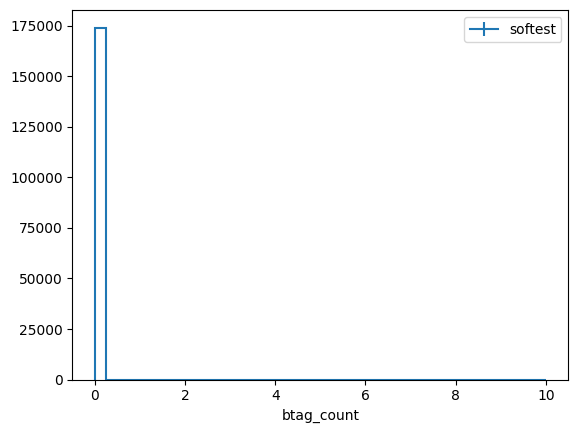

In [20]:
qcd_softb.plot1d(label='softest')
# qcd_midb.plot1d(label='mid')
# qcd_leadb.plot1d(label='leading')
plt.legend()
plt.show()

In [21]:
qcd_softpt = make_scaled_hist('goodjets', 'pt', 450, 1600, bins=40, which_index=2, absv=False)
qcd_midpt = make_scaled_hist('goodjets', 'pt', 450, 1600, bins=40, which_index=1, absv=False)
qcd_leadpt = make_scaled_hist('goodjets', 'pt', 450, 1600, bins=40, which_index=0, absv=False)

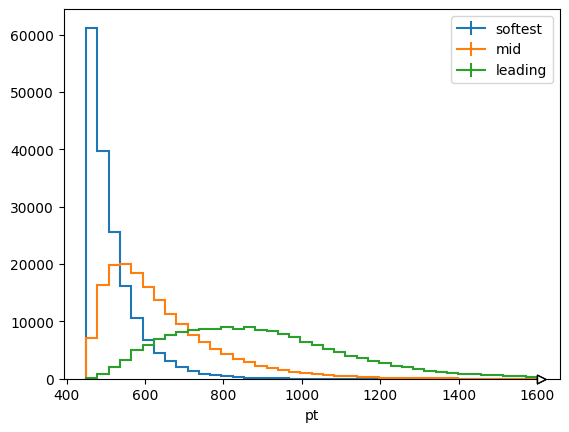

In [22]:
qcd_softpt.plot1d(label='softest')
qcd_midpt.plot1d(label='mid')
qcd_leadpt.plot1d(label='leading')
plt.legend()
# plt.yscale('log')
plt.show()

In [23]:
qcd_test = qcd['qcd_470to600']

In [24]:
qcd_test['goodjets', 'eta_cut'] = (
    abs(qcd_test.goodjets.eta[:, 2]) - 
     abs(qcd_test.goodjets.eta[:, 0] - qcd_test.goodjets.eta[:, 1])
)

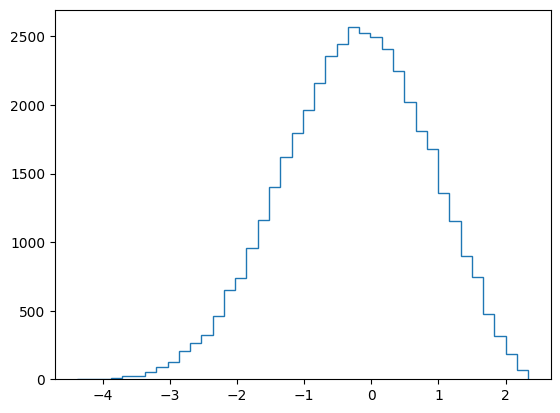

In [25]:
plt.hist(ak.firsts(qcd_test.goodjets.eta_cut), bins=40, histtype='step')
plt.show()

In [26]:
qcd_test['goodjets', 'isGluon'] = qcd_test.GenJetAK8.partonFlavour[:,2] == 21

In [27]:
gluon_eta = qcd_test.goodjets.eta_cut[ak.firsts(qcd_test.goodjets.isGluon)]

In [28]:
quark_eta = qcd_test.goodjets.eta_cut[ak.firsts(~qcd_test.goodjets.isGluon)]

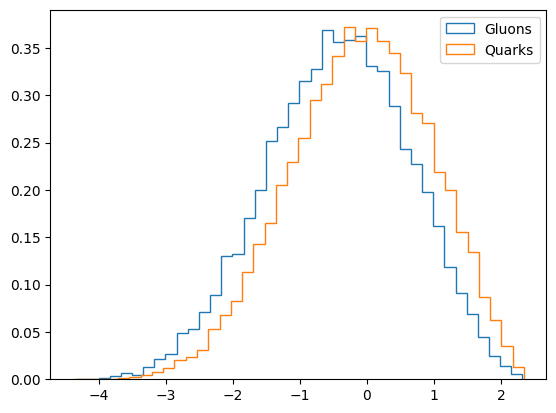

In [29]:
plt.hist(ak.firsts(gluon_eta), bins=40, label='Gluons', histtype='step', density=True)
plt.hist(ak.firsts(quark_eta), bins=40, label='Quarks', histtype='step', density=True)
plt.legend()
plt.show()

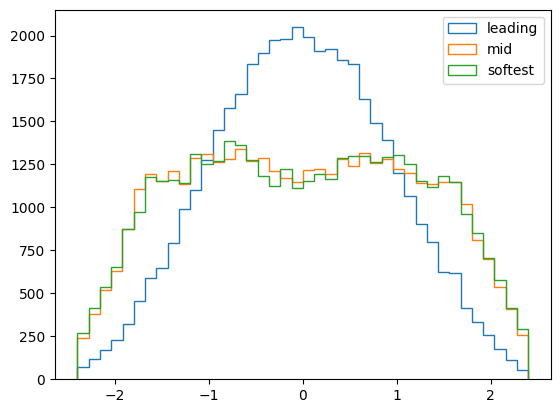

In [30]:
plt.hist(qcd_test.goodjets.eta[:, 0], bins=40, label='leading', histtype='step')
plt.hist(qcd_test.goodjets.eta[:, 1], bins=40, label='mid', histtype='step')
plt.hist(qcd_test.goodjets.eta[:, 2], bins=40, label='softest', histtype='step')
plt.legend()
plt.show()

In [32]:
ak.flatten(qcd['qcd_1000to1400'].goodjets[qcd['qcd_1000to1400'].goodjets.isGluon]).isGluon

<Array [True, True, True, True, ..., True, True, True] type='1034024 * bool'>

In [25]:
path = '/project01/ndcms/cmoore24/skims/gluon_finding/truth_samples/gluons'
for i in  qcd:
    gluon_sample = ak.flatten(qcd[i].goodjets[qcd[i].goodjets.isGluon])
    ak.to_parquet(gluon_sample, f'{path}/{i}.parquet')

In [26]:
gluon_sample.isGluon

<Array [True, True, True, True, ..., True, True, True] type='743310 * bool'>